In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
data_dir = 'hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
image_datasets['train'][1]

(tensor([[[ 1.6324,  1.4783,  0.8961,  ..., -0.1657, -0.2171, -0.0801],
          [ 1.6153,  1.3242,  1.1187,  ..., -0.2171, -0.4911, -0.1999],
          [ 1.5468,  1.5639,  1.4440,  ...,  0.1254, -0.0458, -0.0287],
          ...,
          [ 1.8550,  1.8037,  1.7865,  ...,  0.4337,  0.3481,  0.2624],
          [ 1.8722,  1.9064,  1.9064,  ...,  0.8104,  0.7248,  0.6221],
          [ 1.9235,  1.9920,  1.9749,  ...,  1.0502,  1.0673,  1.1187]],
 
         [[ 1.5182,  1.2731,  0.3102,  ..., -0.2675, -0.3025, -0.0574],
          [ 1.3782,  0.9580,  0.6078,  ..., -0.1625, -0.4601, -0.1275],
          [ 1.4132,  1.3081,  0.9230,  ...,  0.3978,  0.1877,  0.1877],
          ...,
          [ 1.9034,  1.8158,  1.8158,  ...,  0.4853,  0.3978,  0.2927],
          [ 1.9559,  1.9909,  1.9909,  ...,  0.8880,  0.8004,  0.6604],
          [ 1.9559,  2.0259,  2.0259,  ...,  1.1155,  1.1331,  1.1856]],
 
         [[ 1.4025,  1.0365,  0.0779,  ..., -0.4973, -0.4450, -0.3753],
          [ 1.2108,  0.4091,

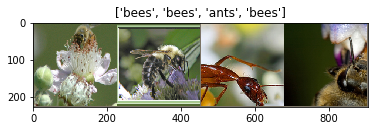

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [17]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6253 Acc: 0.7254
val Loss: 0.1789 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4179 Acc: 0.8156
val Loss: 0.4253 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.6255 Acc: 0.7500
val Loss: 0.4050 Acc: 0.8758

Epoch 3/24
----------
train Loss: 0.4405 Acc: 0.8115
val Loss: 0.2049 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.4492 Acc: 0.8115
val Loss: 0.3232 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4882 Acc: 0.7869
val Loss: 0.3101 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4924 Acc: 0.8238
val Loss: 0.3792 Acc: 0.8431

Epoch 7/24
----------
train Loss: 0.4110 Acc: 0.8197
val Loss: 0.2399 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3845 Acc: 0.8607
val Loss: 0.2364 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2786 Acc: 0.8893
val Loss: 0.2289 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3953 Acc: 0.8607
val Loss: 0.2007 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3744 Acc: 0.8525
val Loss: 0.3043 Acc: 0.8954

Ep

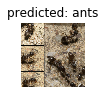

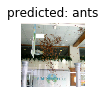

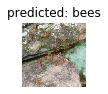

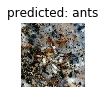

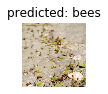

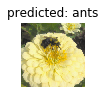

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.9254 Acc: 0.5697
val Loss: 0.3867 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5870 Acc: 0.7500
val Loss: 0.2674 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.3443 Acc: 0.8484
val Loss: 0.1743 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.4024 Acc: 0.8361
val Loss: 0.1735 Acc: 0.9608

Epoch 4/24
----------
train Loss: 0.3559 Acc: 0.8484
val Loss: 0.3288 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.6951 Acc: 0.7131
val Loss: 0.2019 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4576 Acc: 0.8115
val Loss: 0.3694 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.2998 Acc: 0.8811
val Loss: 0.2158 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.3288 Acc: 0.8607
val Loss: 0.2368 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3485 Acc: 0.8484
val Loss: 0.1806 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3575 Acc: 0.8566
val Loss: 0.1767 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3062 Acc: 0.8525
val Loss: 0.2108 Acc: 0.9281

Ep

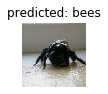

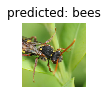

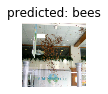

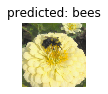

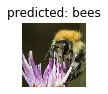

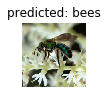

In [40]:
visualize_model(model_conv)

plt.ioff()
plt.show()